In [2]:
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import statsmodels.api as sm

In [3]:
# data = statcast('2017-04-01', '2017-10-30')
# data.to_csv("2017data.csv")
# data.head()

In [4]:
rawData = pd.read_csv("2017data.csv")
del rawData ['Unnamed: 0']
# rawData.head()

/Users/michaelhering/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
rData = rawData.copy()
# rData.head()

In [6]:
# Let's keep the columns for events, estimated_woba_using_speedangle, hc_x, hc_y, hit_distance_sc, launch_speed,
# launch_angle, home_team, hit_location, 

data = rawData[['events', 'estimated_woba_using_speedangle','hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'home_team', 'hit_location']]
data = data.dropna()


In [7]:
events = data.groupby(by='events').size()
events = events.sort_values(ascending=False)
# print(events)

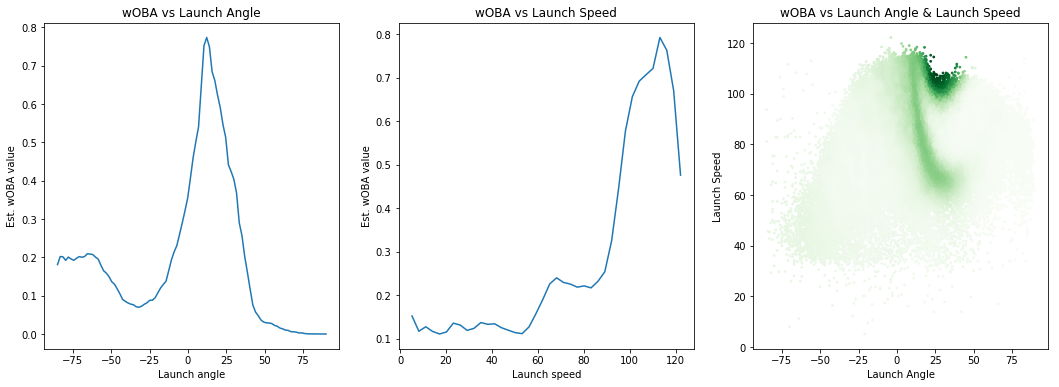

In [8]:
d = data.copy()


#Let's compare hit speed and angle to woba value
Abins = np.linspace(d.launch_angle.min(), d.launch_angle.max(), 100)
Sbins = np.linspace(d.launch_speed.min(), d.launch_speed.max(), 40)
Agroups = d.groupby(np.digitize(d.launch_angle, Abins))
Sgroups = d.groupby(np.digitize(d.launch_speed, Sbins))
AwOBA = Agroups['estimated_woba_using_speedangle'].mean()
SwOBA = Sgroups['estimated_woba_using_speedangle'].mean()


min_max_scaler = preprocessing.MinMaxScaler()
woba_scaled = min_max_scaler.fit_transform(d[['estimated_woba_using_speedangle']])
d['plotColor'] = woba_scaled

fig, [ax1, ax2, ax3] = plt.subplots(1,3,figsize=(18,6))
ax1.set_xlabel("Launch angle")
ax1.set_ylabel("Est. wOBA value")
ax1.set_title("wOBA vs Launch Angle")
ax1.plot(Abins, AwOBA)
ax2.set_xlabel("Launch speed")
ax2.set_ylabel("Est. wOBA value")
ax2.set_title("wOBA vs Launch Speed")
ax2.plot(Sbins, SwOBA)
ax3.set_xlabel("Launch Angle")
ax3.set_ylabel("Launch Speed")
ax3.set_title("wOBA vs Launch Angle & Launch Speed")
ax3.scatter(d.launch_angle, d.launch_speed, c=d.plotColor, cmap='Greens', s=3)

From the graphs above, we can notice that there are certain "sweet spots" of both angle and speed of a hit that will produce the highest wOBA for that hit. 

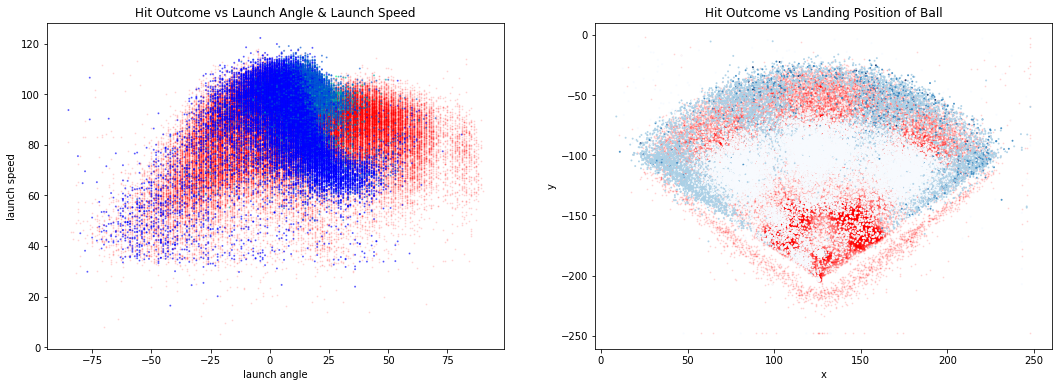

In [9]:
d = data.copy()

# Let's compare hit speed and angle, and position, to events
# we can categorize each event by plotting them as distinct colors

def colorize(row):
    event = row['events']
    if event == 'single': return 1
    elif event == 'double': return 2
    elif event == 'triple': return 3
    elif event == 'home_run': return 4
    else: return 'r'

d['plotColor'] = d.apply(colorize, axis=1)
dNeg = d.loc[d['plotColor'] == 'r']
dPos = d.loc[d['plotColor'] != 'r']

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(18,6))
ax1.set_xlabel("launch angle")
ax1.set_ylabel("launch speed")
ax1.set_title("Hit Outcome vs Launch Angle & Launch Speed")
ax1.scatter(dNeg.launch_angle, dNeg.launch_speed, c='r', s = 1, alpha = 0.1)
ax1.scatter(dPos.launch_angle, dPos.launch_speed, c=dPos.plotColor, cmap='winter', s = 1, alpha = 0.5)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Hit Outcome vs Landing Position of Ball")
ax2.scatter(dNeg.hc_x, -dNeg.hc_y, c='r', s = 1, alpha = 0.1)
ax2.scatter(dPos.hc_x, -dPos.hc_y, c=dPos.plotColor, cmap='Blues', s = 1, alpha = 0.8)

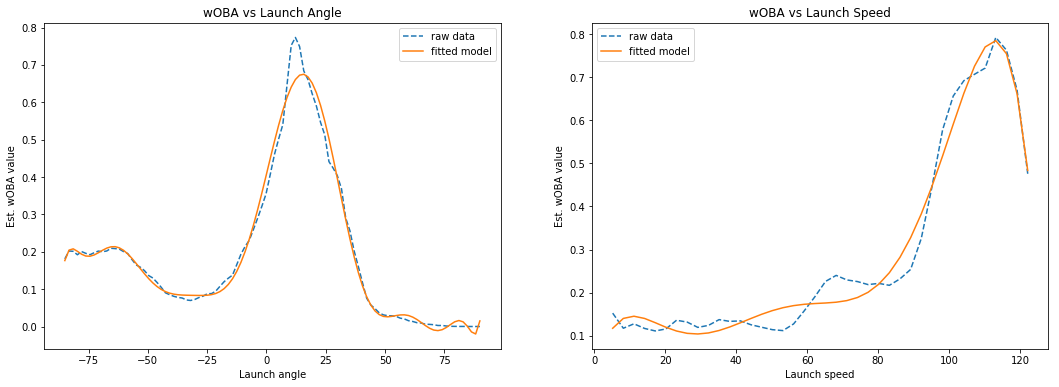

In [10]:
d = data.copy()
# HE : How effective are a player's hits? Let's look at what angle and speed their hits are and then plug these
#  into our MODEL to see 


def SomePoly(k):
    a = [9, 1.5, -12.5, -2.5, 3.5, 1]
    return sum([a[p]*k**p for p in range(len(a))])

#Let's compare hit speed and angle to woba value
Abins = np.linspace(d.launch_angle.min(), d.launch_angle.max(), 100)
Sbins = np.linspace(d.launch_speed.min(), d.launch_speed.max(), 40)
Agroups = d.groupby(np.digitize(d.launch_angle, Abins))
Sgroups = d.groupby(np.digitize(d.launch_speed, Sbins))
AwOBA = Agroups['estimated_woba_using_speedangle'].mean()
SwOBA = Sgroups['estimated_woba_using_speedangle'].mean()

Adegree = 14
Sdegree = 6
Acoefs, Ares, _, _, _ = np.polyfit(Abins,AwOBA, Adegree, full = True)
Scoefs, Sres, _, _, _ = np.polyfit(Sbins,SwOBA, Sdegree, full = True)
Af = np.poly1d(Acoefs)
Sf = np.poly1d(Scoefs)
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(18,6))
ax1.set_xlabel("Launch angle")
ax1.set_ylabel("Est. wOBA value")
ax1.set_title("wOBA vs Launch Angle")
ax1.plot(Abins, AwOBA, "--", label="raw data")
ax1.plot(Abins, Af(Abins), label="fitted model")
ax1.legend()
ax2.set_xlabel("Launch speed")
ax2.set_ylabel("Est. wOBA value")
ax2.set_title("wOBA vs Launch Speed")
ax2.plot(Sbins, SwOBA, "--", label="raw data")
ax2.plot(Sbins, Sf(Sbins), label = "fitted model")
ax2.legend()

Using these models, let's predict the HE of hits for certain batters hits using HE = (Af(angle) + Sf(speed)) / 2

In [11]:
d = rawData.copy()
d = d[['batter', 'events', 'estimated_woba_using_speedangle','hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'home_team', 'hit_location']]
d = d.dropna()
d['HE'] = (Af(d['launch_angle']) + Sf(d['launch_speed'])) / 2
sD = d.copy()

def getName(row):
    batterID = row['batter'];
    batterInfo = playerid_reverse_lookup([batterID], key_type='mlbam');
    name = batterInfo['name_first'] + ' ' + batterInfo['name_last'];
    return name[0];

batters = d.groupby('batter').agg({'events':'count', 'HE':'mean'})
batters = batters.sort_values(by="events")
batters = batters.reset_index()[['batter', 'events', 'HE']]
batters = batters.loc[batters['events'] > 100]
batters = batters.sort_values(by='HE', ascending=False)
batters.head(10)
t10 = batters.head(10)
t10['name'] = t10.apply(getName, axis=1);

Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.


/Users/michaelhering/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
t10.head(10)

,batter,events,HE,name
603,488671.0,169,0.426828,alex avila
775,408234.0,323,0.409941,miguel cabrera
733,592450.0,280,0.409169,aaron judge
630,593934.0,192,0.408557,miguel sano
541,650490.0,112,0.403898,yandy diaz
861,408045.0,416,0.399840,joe mauer
746,570267.0,295,0.399776,domingo santana
553,581527.0,123,0.399313,devon travis
797,443558.0,345,0.398965,nelson cruz
616,500874.0,181,0.398189,jose martinez


Looking at our table we can see the batters, that had over 100 at bats in 2017, with the highest HE score. These are batters whose hits on average produced the best offensive results for their team. 

The interactive widget below will allow us to visualize these player's hits, to clear the output reload the code cell

In [13]:
menu = widgets.Dropdown(options=t10['name'].tolist(), value='alex avila', description='Batter:')
button1 = widgets.Button(description='Plot')
out = widgets.Output()

def colorize(row):
    event = row['events']
    if event == 'single': return 1
    elif event == 'double': return 2
    elif event == 'triple': return 3
    elif event == 'home_run': return 4
    else: return 'r'

def plot():
        batterID = t10.loc[t10['name'] == menu.value, ['batter']]
        batterID = batterID['batter'].values[0]
        d = rawData.copy()
        d = d[['batter', 'events', 'estimated_woba_using_speedangle','hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'home_team', 'hit_location']]
        d = d.dropna()
        d = d.loc[d['batter'] == batterID]
        d['plotColor'] = d.apply(colorize, axis=1)
        dNeg = d.loc[d['plotColor'] == 'r']
        dPos = d.loc[d['plotColor'] != 'r']
        
        fig, [ax1, ax2] = plt.subplots(1,2,figsize=(18,6))
        ax1.set_xlabel("launch angle")
        ax1.set_ylabel("launch speed")
        ax1.set_title(menu.value + ": Hit Outcome vs Launch Angle & Launch Speed")
        ax1.scatter(dNeg.launch_angle, dNeg.launch_speed, c='r', s = 7, alpha = 1)
        ax1.scatter(dPos.launch_angle, dPos.launch_speed, c=dPos.plotColor, cmap='winter', s = 7, alpha = 0.5)
        
        ax2.set_xlabel("x")
        ax2.set_ylabel("y")
        ax2.set_title(menu.value + ": Hit Outcome vs Landing Position of Ball")
        ax2.scatter(dNeg.hc_x, -dNeg.hc_y, c='r', s = 5, alpha = 1)
        ax2.scatter(dPos.hc_x, -dPos.hc_y, c=dPos.plotColor, cmap='Blues', s = 7, alpha = 1)

def on_button_clicked(b):
    with out:
        clear_output() 
    plot()

    
        
button1.on_click(on_button_clicked)
widgets.VBox([menu,button1, out])

In [14]:
d = rawData.copy()
d['HE'] = (Af(d['launch_angle']) + Sf(d['launch_speed'])) / 2
corrD = d[['HE', 'estimated_woba_using_speedangle', 'estimated_ba_using_speedangle']]
(corrD).corr()

,HE,estimated_woba_using_speedangle,estimated_ba_using_speedangle
HE,1.000000,0.772273,0.837640
estimated_woba_using_speedangle,0.772273,1.000000,0.910755
estimated_ba_using_speedangle,0.837640,0.910755,1.000000


The HE statistic is ultimately a measurement of how effective a hit is at producing a positive result for the offense. The two statcast statistics 'estimated_woba_using_speedangle' and 'estimated_ba_using_speedangle' also aim to measure the same thing. Looking at our correlation table we notice that the HE statistic is closely correlated with the estimated wOBA and estimated Batting Average statistics that are provided by statcast.